In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import pandas as pd
import matplotlib.pyplot as plt

数据预处理

In [3]:
train_data = pd.read_csv('california-house-prices/train.csv')
test_x = pd.read_csv('california-house-prices/test.csv')

train_x = train_data.iloc[:, 3:40]
train_x_numeric_features = train_x.dtypes[train_x.dtypes != 'object'].index
train_x = train_x[train_x_numeric_features]
train_x = train_x.apply(
    lambda x : (x - x.mean()) / x.std()
)
train_x = train_x.fillna(0)
train_y = train_data.iloc[:, 2]

test_x = test_x.iloc[:, 1:39]
test_x_numeric_features = test_x.dtypes[test_x.dtypes != 'object'].index
test_x = test_x[test_x_numeric_features]
test_x = test_x.apply(
    lambda x : (x - x.mean()) / x.std()
)
test_x = train_x.fillna(0)

train_x = torch.tensor(train_x.values, dtype = torch.float32)
train_y = torch.tensor(train_y.values, dtype = torch.float32)
test_x = torch.tensor(test_x.values, dtype = torch.float32)

定义网络

In [3]:
loss = nn.MSELoss()
num_inputs, num_outputs = train_x.shape[1], 1

def log_rmse(y_hat, y):
    clipped_preds = torch.clamp(y_hat, 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(y)))
    return rmse

def get_net():
    net = nn.Sequential(nn.Linear(num_inputs, num_outputs))
    net.apply(init_weights)
    return net

def init_weights(m):
    if type(m) == nn.Module:
        nn.init.normal_(m.weight, mean = 0, std = 1)
        nn.init.zeros_(m.bias)

交叉验证

In [4]:
def get_k_fold_data(k, i, train_x, train_y):

    assert k > 1

    fold_size = train_x.shape[0] // k

    cross_train_x, cross_train_y = None, None
    cross_validate_x, cross_validate_y = None, None

    for j in range(k):

        idx = slice(j * fold_size, (j + 1) * fold_size)
        x_part, y_part = train_x[idx], train_y[idx]

        if j == i:
            cross_validate_x, cross_validate_y = x_part, y_part
        elif cross_train_x is None:
            cross_train_x, cross_train_y = x_part, y_part
        else:
            cross_train_x = torch.cat([cross_train_x, x_part], dim = 0)
            cross_train_y = torch.cat([cross_train_y, y_part], dim = 0)

    return cross_train_x, cross_train_y, cross_validate_x, cross_validate_y

In [5]:
def k_fold(k, train_x, train_y, cross_batch_size, epochs, lr, weight_decay, net):

    cross_train_l_sum, cross_validate_l_sum = 0.0, 0.0

    for i in range(k):
        cross_train_x, cross_train_y, cross_validate_x, cross_validate_y = get_k_fold_data(k, i, train_x, train_y)

        cross_train_iter = d2l.load_array((cross_train_x, cross_train_y), batch_size = cross_batch_size)
        cross_validate_iter = d2l.load_array((cross_validate_x, cross_validate_y), batch_size = cross_batch_size, is_train = False)

        cross_net = net

        cross_train_l_sum += train(epochs, cross_train_iter, lr, weight_decay, cross_net, True)
        cross_validate_l_sum += test(cross_validate_iter, cross_net)

    return cross_train_l_sum / k, cross_validate_l_sum / k

训练和测试

In [6]:
def train(epochs, train_iter, lr, weight_decay, net, is_cross_train = False):

    updater = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = weight_decay)

    loss_list = []
    epoch_list = []

    for epoch in range(epochs):

        metric = d2l.Accumulator(2)

        for x, y in train_iter:

            x = x.to(torch.device('cuda'))
            y = y.to(torch.device('cuda'))

            updater.zero_grad()
            y_hat = net(x)
            l = log_rmse(y_hat, y.reshape(y_hat.shape))
            l.sum().backward()
            updater.step()

            metric.add(l.sum(), l.numel())

        epoch_loss = metric[0] / metric[1]
        loss_list.append(epoch_loss)
        epoch_list.append(epoch + 1)

        if not is_cross_train:
            plt.plot(epoch_list, loss_list)

    return epoch_loss

def test(test_iter, net):

    metric = d2l.Accumulator(2)

    for x, y in test_iter:
        with torch.no_grad():

            x = x.to(torch.device('cuda'))
            y = y.to(torch.device('cuda'))

            y_hat = net(x)
            l = log_rmse(y_hat, y.reshape(y_hat.shape))

            metric.add(l.sum(), l.numel())

    return metric[0] / metric[1]

调参

In [7]:
cross_epochs = 200
weight_decay = 0
lr = 1300
cross_batch_size = 128

交叉验证

In [8]:
net = get_net()
net.to(torch.device('cuda'))

cross_train_loss, cross_validate_loss = k_fold(5, train_x, train_y, cross_batch_size, cross_epochs, lr, weight_decay, net)
print('lr:',lr,'batch_size:',cross_batch_size)
print('train loss:', cross_train_loss)
print('validate loss:', cross_validate_loss)

普通的设验证集

In [9]:
fold_size = train_x.shape[0] // 2
cross_train_x, cross_train_y = train_x[slice(0 * fold_size, 1 * fold_size)], train_y[slice(0 * fold_size, 1 * fold_size)]
cross_validate_x, cross_validate_y = train_x[slice(1 * fold_size, 2 * fold_size)], train_y[slice(1 * fold_size, 2 * fold_size)]

cross_train_iter = d2l.load_array((cross_train_x, cross_train_y), cross_batch_size)
cross_validate_iter = d2l.load_array((cross_validate_x, cross_validate_y), cross_batch_size, False)

net = get_net()
net.to(torch.device('cuda'))

print(train(cross_epochs, cross_train_iter, lr, weight_decay, net, True))
print(test(cross_validate_iter, net))

真正的训练模型

0.2521665247704462

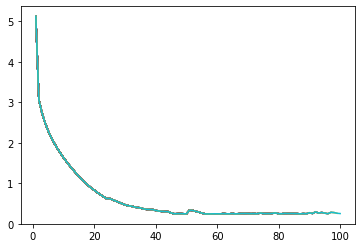

In [10]:
batch_size, epochs = 128, 100
lr = 1300

train_iter = d2l.load_array((train_x, train_y), batch_size)

net = get_net()
net.to(torch.device('cuda'))

train(epochs, train_iter, lr, weight_decay, net)

保存预测结果

In [30]:
test_x = test_x.to(torch.device('cuda'))
predict = net(test_x)
predict = predict.to(torch.device('cpu'))
predict = predict.detach().numpy()

sample_submission = pd.read_csv('california-house-prices/sample_submission.csv')
sample_submission['Sold Price'] = pd.Series(predict.reshape(1, -1)[0])
submission = pd.concat([sample_submission['Id'], sample_submission['Sold Price']], axis=1)
submission.to_csv('california-house-prices/submission.csv', index=False)